In [192]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
from tensorflow.keras import layers, models

In [116]:
df = pd.read_csv('HAM10000_metadata.csv') # Reading the CSV file into pandas dataframe

In [112]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [113]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [114]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [115]:
df.isnull().sum() 

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

__________________________________________________________
### Only "age" attribute has missing values

### We will fill the null values with the mean of the column

_________________________________________________________

In [117]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [118]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

_________

### There are seven types of categories in the target variable. To understand the data mre clearly, we are going to make a new column with the full form of the cancer name.

### For that, we will create a dictionary with keys as the shortform and values as the fullforms.
_________

In [119]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = 'skin-cancer-mnist-ham10000'

### Merge images from both folders into one dictionary

In [120]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

### The image data is saved in the folder named "skin-cancer-mnist-ham10000" folder, which is in the same directory

### We are going to create another column named " path". In that column we are going to add the path of each respective image using the common column of "image_id" which has the records of unique image id of each image. 

In [123]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,2


In [124]:
df.cell_type.value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

### The value count shows that the data is imbalanced. 
> #### The Dermatofibroma category of cancer has only 115 images, whereas the Melanocytic nevi has 6000 images
> #### We are going to use image generator for this further. 

In [126]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

### We have merged the images in the dataset using map function on the "path" column.

### While merging, we have resized the images into 125 by 100 (height, width)

### Let us have a look 5 samples of each category

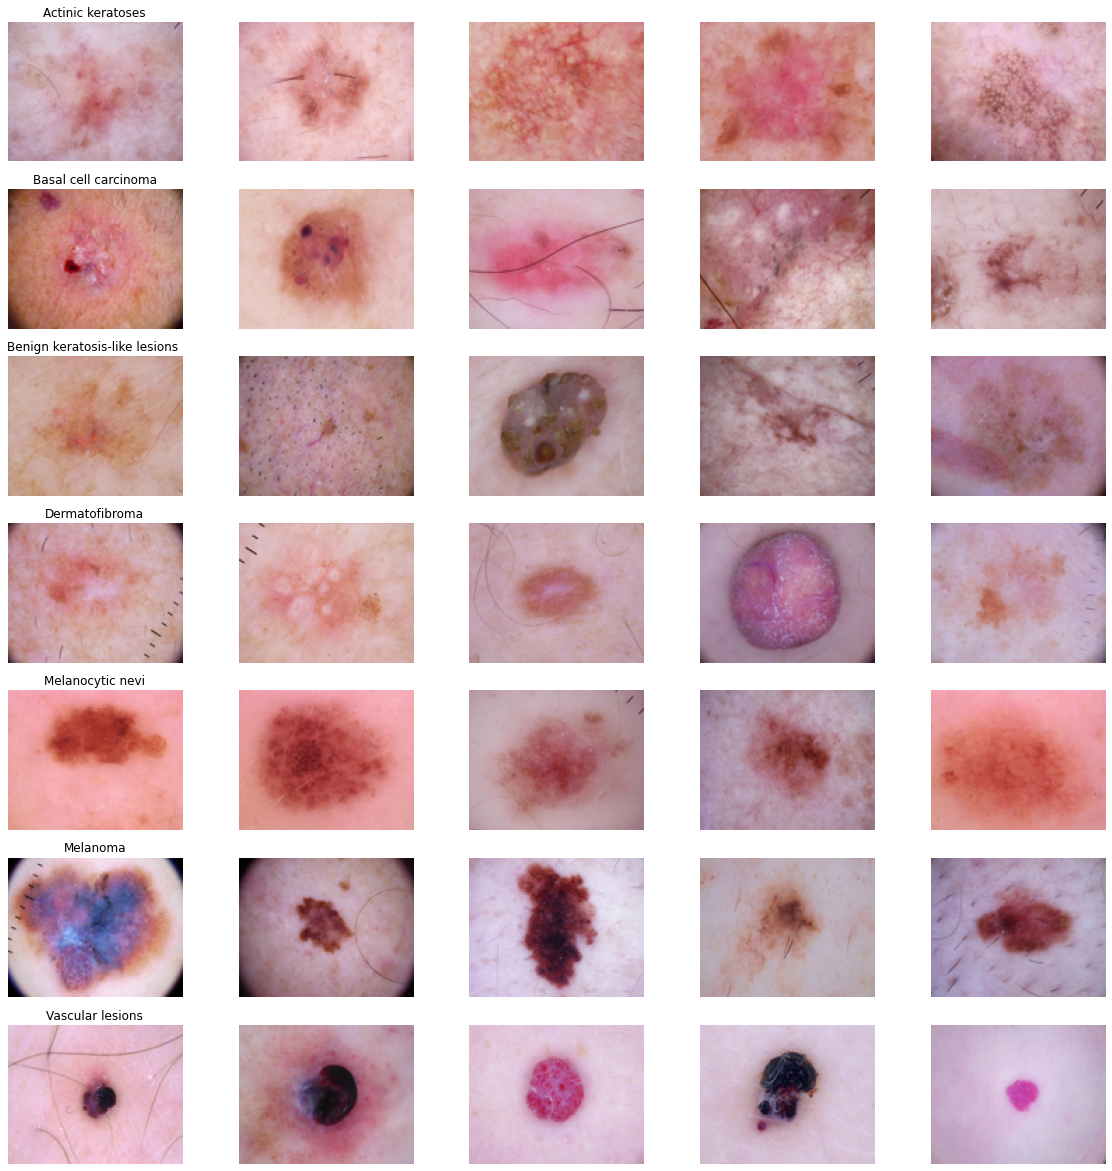

In [128]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [129]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

(100, 125, 3)    10015
Name: image, dtype: int64

### Exploratory Data Analysis

> The age column has some records with value o
> The sex column has some recirds with value "unknown"

#### We are goinh to drop such records since the number of records is not big as compared to total records we have

In [132]:
df.age.value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
51.0      57
10.0      41
0.0       39
Name: age, dtype: int64

In [133]:
df.sex.value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [134]:
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

### Visualizations and Interoretations

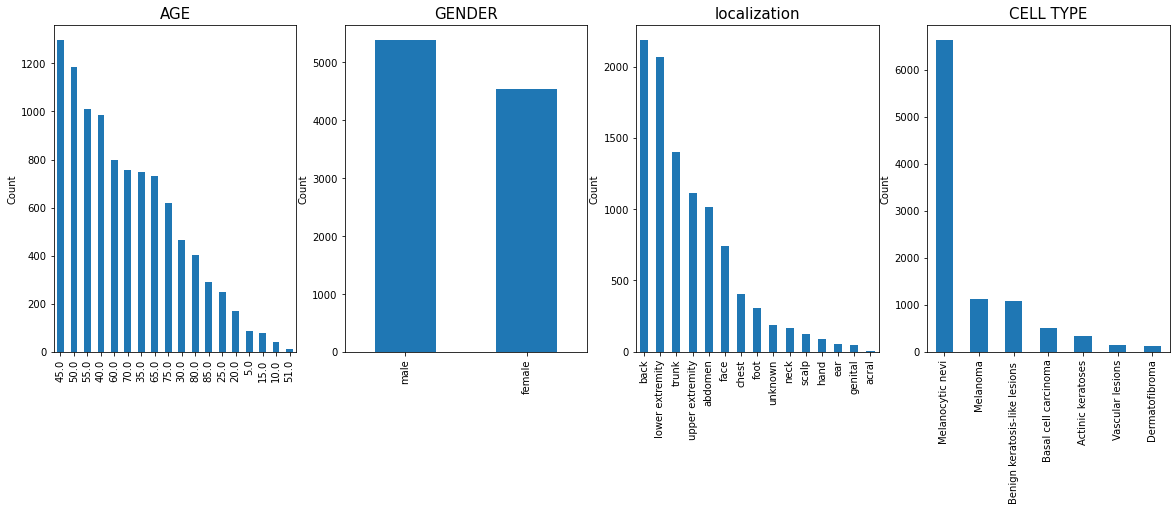

In [249]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()
plt.savefig("visualizations/barplots.png")

### with the above visualizations, we can interprete below observations:
- #### As the age increases, there chances of having cancer get more
- #### Male having cancer are more than female having the cancer
- #### probability of having spots on the back, lower extremity,and truck is more than that on the other body parts.
- #### Melanocytic nevi is the most common cancer.

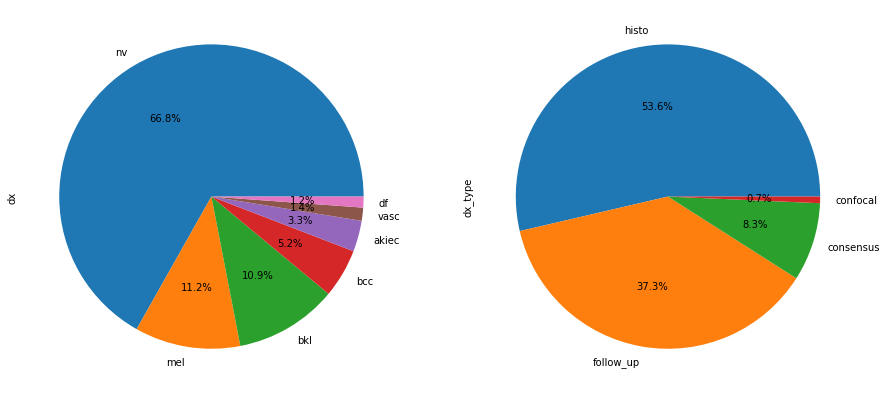

<Figure size 432x288 with 0 Axes>

In [250]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()
plt.savefig("visualizations/piecharts.png")

### From the above pie charts, it could be interpretated that:
- #### There is 66.80 % cahnce of only Melanocytic cancer
- #### Most probably the cance is detected through the HIstopathology diagnosis

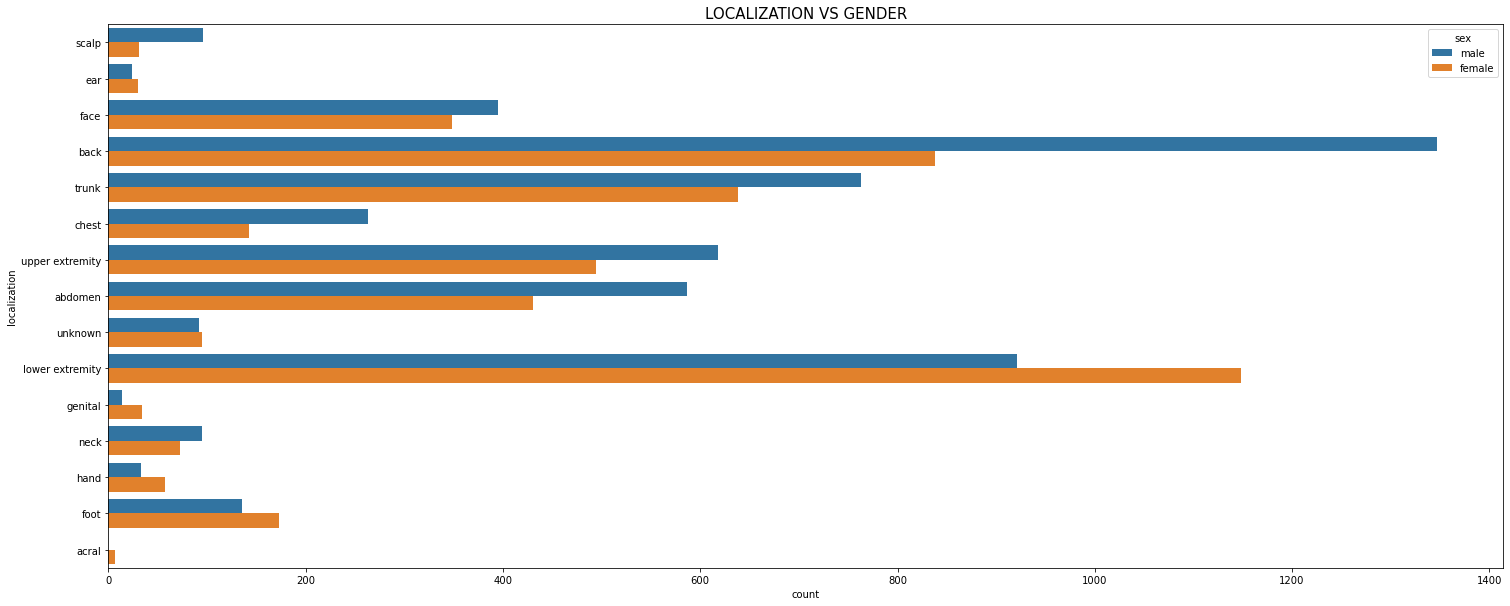

In [251]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)
plt.savefig("visualizations/loc_vs_gebder.png")

- #### Among males, the chances of having symtoms / spots on the back are more, whereas
- #### Among females, the chances of the symptoms / spots on the lower extremity are more.

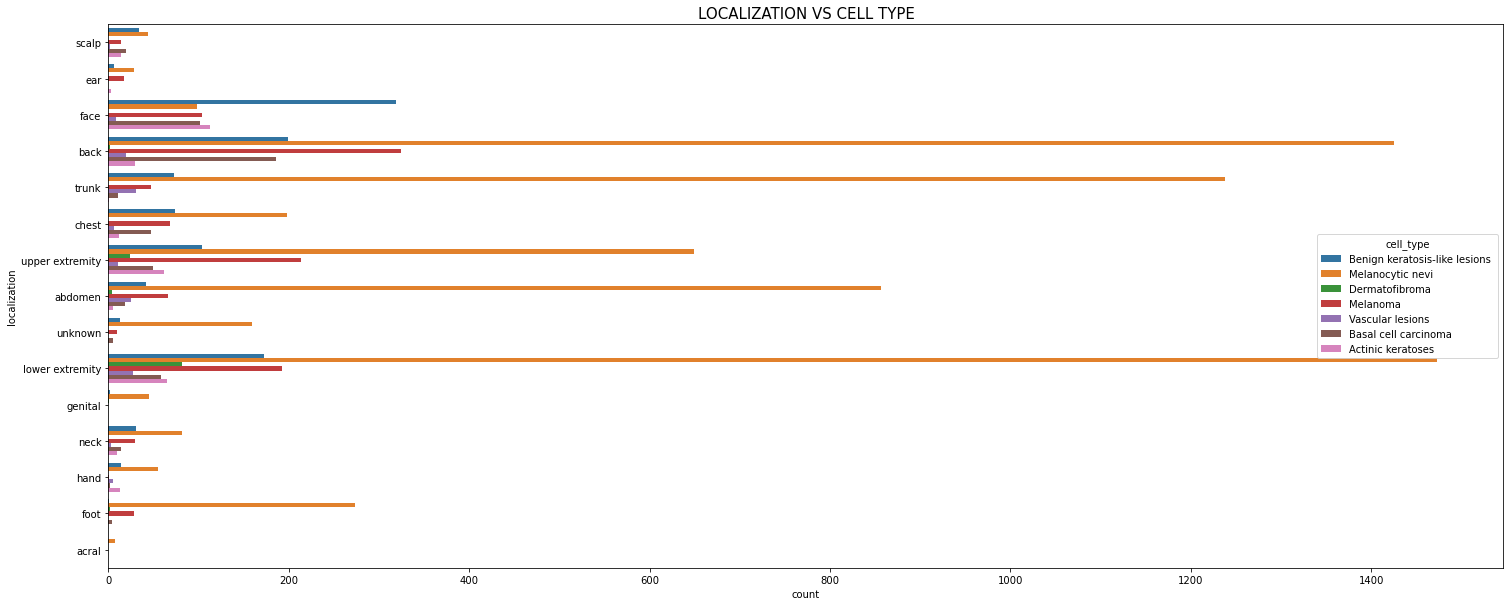

In [252]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(y='localization', hue='cell_type',data=df)
plt.savefig("visualizations/loc_vs_cell_type.png")

- #### If the symptoms / spots are on the back, trunk or lower extremity, most probably the cancer type is Melanocytic nevi.
- #### After Melanocytic nevi, the probability of Melanoma is more for the symptoms / spots on the body parts mentioned in above point

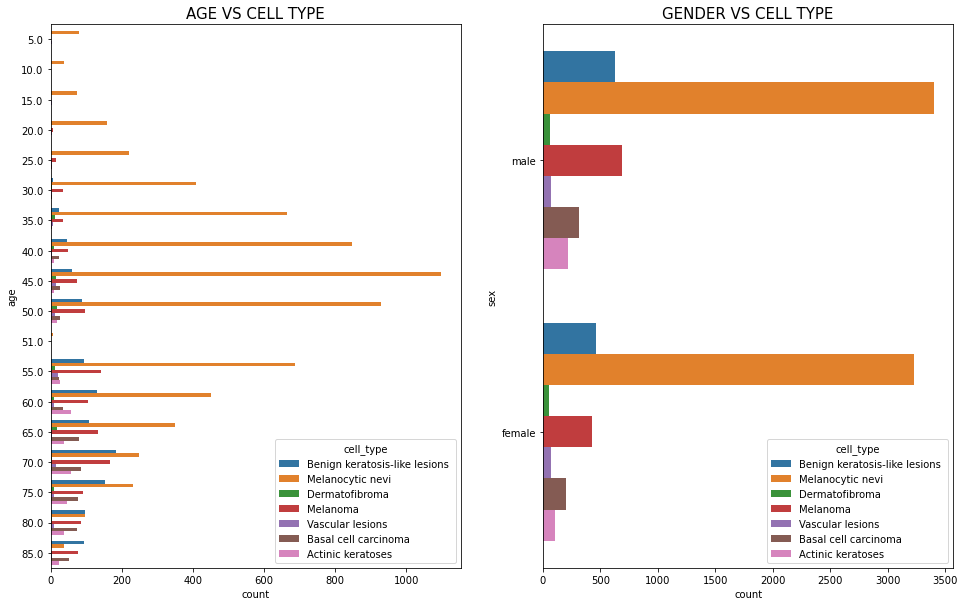

In [253]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)
plt.savefig("visualizations/AGE_VS_CELL_GEN_vs_Cell_type.png")

- #### The first distribution is the normal diostribution.
- #### It shows that, the age group of 35 to 50 has more chance of cancer.
- #### There is similar distribution of all the cancers in both the genders.

## ANN model building

In [142]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

### Before building model, we are going to preprocess the data.
- ### Separate the column "cell_type_idx" from feature columns as it is the target column.
- ### split the datasets into training  and testing in the ratio of 75 to 25.
- ### convert the image data into array type using numpy.
- ### Normalize the image data (array format) in x_train and x_test.
- ### Apply one hot encoding on the target column.

In [175]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [176]:
features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin-cancer-mnist-ham10000/HAM10000_images_par...,Benign keratosis-like lesions,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [207]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Actinic keratoses', b'Vascular lesions',
       b'Benign keratosis-like lesions ', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7440,), dtype=int32, numpy=array([0, 1, 2, ..., 1, 0, 0], dtype=int32)>)

In [208]:
x_train_df.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
5494,HAM_0000594,ISIC_0029178,nv,follow_up,50.0,female,abdomen,skin-cancer-mnist-ham10000/HAM10000_images_par...,Melanocytic nevi,"[[[230, 157, 179], [232, 159, 180], [231, 158,..."
2646,HAM_0005435,ISIC_0025752,bcc,histo,65.0,male,back,skin-cancer-mnist-ham10000/HAM10000_images_par...,Basal cell carcinoma,"[[[191, 179, 187], [193, 182, 191], [194, 183,..."


In [209]:
x_train = np.asarray(x_train_df['image'].tolist())
x_test = np.asarray(x_test_df['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [210]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_df, num_classes = 7)
y_test = to_categorical(y_test_df, num_classes = 7)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [285]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

In [286]:
x_train = x_train.reshape(6696,125*100*3)
x_test = x_test.reshape(2481,125*100*3)
print(x_train.shape)
print(x_test.shape)

(6696, 37500)
(2481, 37500)


In [287]:

ANN = Sequential()

ANN.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
ANN.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
ANN.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

optimizer = tf.keras.optimizers.Adam(lr = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
ANN.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the keras model on the dataset
history = ANN.fit(x_train, y_train, batch_size = 10, epochs = 5)

accuracy = ANN.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

/Users/vloggerbhaai/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5


2022-08-02 17:43:10.850643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


670/670 [==============================] - 11s 12ms/step - loss: 0.9773 - accuracy: 0.6668
Epoch 2/5
670/670 [==============================] - 7s 11ms/step - loss: 0.8995 - accuracy: 0.6819
Epoch 3/5
670/670 [==============================] - 7s 11ms/step - loss: 0.8573 - accuracy: 0.6958
Epoch 4/5
670/670 [==============================] - 8s 12ms/step - loss: 0.8161 - accuracy: 0.7083
Epoch 5/5
670/670 [==============================] - 8s 12ms/step - loss: 0.7838 - accuracy: 0.7128


2022-08-02 17:43:53.312229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 13ms/step - loss: 0.8603 - accuracy: 0.6900
Test: accuracy =  69.00443434715271 %


In [291]:
y_pred = ANN.predict(x_test)
y_pred_ann_class = [np.argmax(element) for element in y_pred]
print(y_test_df[:40])
print(y_pred_ann_class[:40])

3569     4
3781     4
9128     4
303      2
5709     4
3836     4
940      2
9105     4
5626     4
3375     4
8546     4
9249     4
8108     4
9566     4
7328     4
3414     4
1281     5
7301     4
4067     4
827      2
7969     4
10014    5
6250     4
1038     2
7696     4
8126     4
209      2
9196     4
1286     5
7403     4
6783     4
5834     4
1987     5
3094     4
7788     4
108      2
2183     5
3131     4
6336     4
2255     5
Name: cell_type_idx, dtype: int8
[4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4]


# CNN model building
> ### Since we observed before that data is highly imbalanced, we are going to perform Data Augumentation using Image generator.

##### Importing libraries

In [217]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [220]:
# import image module
from IPython.display import Image

### Set the CNN model
- #### The CNN architechture is:
> In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense*2 -> Dropout -> Ou

In [228]:
# get the image
Image(url="CNNnetwork.jpg", width=700, height=200)

In [229]:

input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 125, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 62, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 62, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 31, 64)       

In [230]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [231]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [232]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [234]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))


In [235]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [236]:
x_train.shape

(6026, 100, 125, 3)

### Now, we are fitting the model with 50 epochs
### Also we will perform data augumentation to overcome the problem of data imbalance.

In [238]:
# Fit the model
epochs = 50
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

Epoch 1/50
376/376 [==============================] - ETA: 0s - loss: 0.9263 - accuracy: 0.6704

2022-08-02 10:21:00.574386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 30s 76ms/step - loss: 0.9263 - accuracy: 0.6704 - val_loss: 0.9471 - val_accuracy: 0.6627
Epoch 2/50
376/376 [==============================] - 27s 70ms/step - loss: 0.8645 - accuracy: 0.6800 - val_loss: 0.8870 - val_accuracy: 0.6731
Epoch 3/50
376/376 [==============================] - 26s 70ms/step - loss: 0.8174 - accuracy: 0.6952 - val_loss: 0.8623 - val_accuracy: 0.6806
Epoch 4/50
376/376 [==============================] - 26s 70ms/step - loss: 0.7839 - accuracy: 0.7115 - val_loss: 0.8100 - val_accuracy: 0.7000
Epoch 5/50
376/376 [==============================] - 26s 70ms/step - loss: 0.7546 - accuracy: 0.7228 - val_loss: 0.8032 - val_accuracy: 0.7015
Epoch 6/50
376/376 [==============================] - 27s 71ms/step - loss: 0.7280 - accuracy: 0.7316 - val_loss: 0.7549 - val_accuracy: 0.7209
Epoch 7/50
376/376 [==============================] - 27s 72ms/step - loss: 0.7109 - accuracy: 0.7391 - val_loss: 0.7745 - val_accuracy: 0.7149
Epo

### The accuracy we got is 76 %, which can be considered as a good accuracy.

### Now let us evaluate the accuracy with testing data:

In [50]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

19/19 [==============================] - 1s 49ms/step - loss: 0.6260 - accuracy: 0.7711
Validation: accuracy = 0.771144  ;  loss_v = 0.625991
Test: accuracy = 0.768239  ;  loss = 0.634390


#### The accuracy with test data evaluation is 76% 
### Hence, we can consider that,with data augumentation, we have overcome the problem of imbalanced distribution of data.

## Comparing ANN and CNN

In [243]:
y_pred_cnn = model.predict(x_test)

In [244]:
y_pred_class_cnn = [np.argmax(element) for element in y_pred_cnn]
y_pred_class_cnn[:5]

[4, 4, 4, 2, 4]

In [248]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification report for ANN model: \n")
print(classification_report(y_pred_ann_class, y_test_df))

print("\n")

print("Classification report for CNN model: \n")
print(classification_report(y_pred_class_cnn, y_test_df))

Classification report for ANN model: 

              precision    recall  f1-score   support

           0       0.04      0.15      0.07        20
           1       0.41      0.39      0.40       135
           2       0.21      0.55      0.30       102
           3       0.00      0.00      0.00         0
           4       0.96      0.74      0.84      2173
           5       0.03      0.40      0.05        20
           6       0.18      0.23      0.20        31

    accuracy                           0.70      2481
   macro avg       0.26      0.35      0.27      2481
weighted avg       0.88      0.70      0.77      2481



Classification report for CNN model: 

              precision    recall  f1-score   support

           0       0.48      0.39      0.43        87
           1       0.58      0.52      0.55       141
           2       0.57      0.60      0.58       257
           3       0.00      0.00      0.00         0
           4       0.92      0.88      0.90      174

/Users/vloggerbhaai/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vloggerbhaai/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vloggerbhaai/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

# Conclusion:

- CNN is more ideal for this image dataset
- The provided dataset has data imbalance imbalance, and we could overcome this issue with the help of data augumentation
- 